# Importing Libraries

In [2]:
import json
import pandas as pd
import numpy as np
import calendar
import re
import matplotlib.pyplot as plt

# Transactional Data at First Glance

The json file which contains the transactional data will be read and stored in the memory as pandas dataframe. To perform an analysis, we take a copy of this dataframe to prevent modification of the original one.

Below is the first few rows of the transactional data.

Notice that under 'transaction_items' column, all items and quantities bought by the customer are all in one cell. The general format of data is 'brand1,product1,(xquantity1);brand1,product1,(xquantity1)'. The product is semi-colon separated from the other product.

In [5]:
transactional_data = None
with open('transaction-data-adhoc-analysis.json', 'r') as file:
    transactional_data = json.load(file)
transactional_data = pd.DataFrame(transactional_data)

In [21]:
transactional_data.head(5)

,address,birthdate,mail,name,sex,username,transaction_items,transaction_value,transaction_date
0,USNS Wagner\nFPO AE 00917,1926/03/11,watsonbrenda@gmail.com,Jennifer Campbell,F,veronicawells,"Exotic Extras,Beef Chicharon,(x4)",5196,2022/01/12
1,USCGC Benson\nFPO AP 48794,2016/07/08,moorelisa@gmail.com,Melissa Kim,F,cgilbert,"Exotic Extras,Beef Chicharon,(x3);HealthyKid 3...",12056,2022/01/12
2,USCGC Benson\nFPO AP 48794,2016/07/08,moorelisa@gmail.com,Melissa Kim,F,cgilbert,"HealthyKid 3+,Gummy Vitamins,(x3);HealthyKid 3...",5500,2022/01/08
3,USCGC Benson\nFPO AP 48794,2016/07/08,moorelisa@gmail.com,Melissa Kim,F,cgilbert,"HealthyKid 3+,Yummy Vegetables,(x1)",500,2022/01/10
4,"33911 Hansen Loaf\nWest Sandra, ND 54188",1949/09/27,michael78@yahoo.com,Kristen Cooper,F,qhernandez,"Candy City,Orange Beans,(x3);Candy City,Gummy ...",2697,2022/01/24


# Clean and Transform the Data

Before describing or summarizing our data, we will perform the following:

1. Get all the relevant data (drop columns that are no longer needed)

2. Segregate the multiple items in the 'transaction_items' columns into separate rows. Further break them down by placing the brand, product, and quantity into their respective columns.

3. Store the transformed table into the memory for further analysis

In [30]:
def clean_transform_data(transactional_data):
    #Create a copy of the original data to prevent modification of the original data
    trans_data = transactional_data.copy()
    
    #Segregate the individual items in the 'transaction_items' column into separate rows
    #Note the other columns will have same values
    trans_data['transaction_items'] = trans_data['transaction_items'].str.split(';')
    
    #Add 'unique_item_sold' columns which determines the number of unique items sold
    trans_data['unique_items_sold'] = trans_data['transaction_items'].map(lambda e: len(e))
    
    #Put individual items into separate rows
    trans_data = trans_data.explode('transaction_items')
    
    #Break down further the 'transaction_items' column. That is, segragate the brand, product and quantity
    #into separate columns
    trans_data['transaction_items'] = trans_data['transaction_items'].str.split(',')
    trans_data[['brand', 'product', 'quantity']] = pd.DataFrame(trans_data['transaction_items'].tolist(), index=trans_data.index)
    
    #Extract only the figure from the string since the 'quantity' column at the point
    #is still '(x<some_number>)' format. For example: (x10)
    trans_data['quantity'] = trans_data['quantity'].apply(lambda value: re.findall(r'\d+', value)[0])
    
    #Drop the 'transaction_items' as this is no longer needed
    trans_data.drop(columns='transaction_items', inplace=True)
    
    trans_data.to_csv('for_checking.csv')
    
    #Retrieve only the relevant columns for our descriptive statistics
    trans_data = trans_data[['name', 'username', 'brand', 'product', 'quantity', 'transaction_value', 'transaction_date', 'unique_items_sold']]
    
    #Convert the quantity field into integer
    trans_data['quantity'] = trans_data['quantity'].astype(str).astype(int)
    
    #Return the transformed data
    return trans_data
    

In [31]:
transformed_data = clean_transform_data(transactional_data)
transformed_data

,name,username,brand,product,quantity,transaction_value,transaction_date,unique_items_sold
0,Jennifer Campbell,veronicawells,Exotic Extras,Beef Chicharon,4,5196,2022/01/12,1
1,Melissa Kim,cgilbert,Exotic Extras,Beef Chicharon,3,12056,2022/01/12,3
1,Melissa Kim,cgilbert,HealthyKid 3+,Nutrional Milk,4,12056,2022/01/12,3
1,Melissa Kim,cgilbert,Candy City,Orange Beans,1,12056,2022/01/12,3
2,Melissa Kim,cgilbert,HealthyKid 3+,Gummy Vitamins,3,5500,2022/01/08,2
...,...,...,...,...,...,...,...,...
83034,Donald Andersen,llowe,HealthyKid 3+,Nutrional Milk,2,4280,2022/06/09,2
83034,Donald Andersen,llowe,Candy City,Gummy Worms,2,4280,2022/06/09,2
83035,Stephanie Russell,cmcdowell,HealthyKid 3+,Nutrional Milk,1,2639,2022/06/03,3
83035,Stephanie Russell,cmcdowell,Candy City,Gummy Worms,3,2639,2022/06/03,3


# Retrieving the Unit Cost of the Items

Unit cost per item is stored in a variable to be accessed later in our analysis

In [32]:
def get_unit_cost(data):
    #Retrieve only relevant information
    df = data[['brand', 'product', 'quantity', 'unique_items_sold', 'transaction_value']].copy()
    
    #Convert the 'quantity' field into integer
    df['quantity'] = df['quantity'].astype(str).astype(int)
        
    #Do this to get the unique combination of brand and product
    unique_items = df.groupby(['brand','product']).size().reset_index()
       
    unit_cost_dict = {}
    #Get the unit cost of each item and store in a dictionary
    for i in unique_items.index:
        brand = unique_items.loc[i, 'brand']
        product = unique_items.loc[i, 'product']        
        unit_cost = df.loc[(df['brand'] == brand) & (df['product'] == product) 
                           & (df['quantity'] == 1) & (df['unique_items_sold'] == 1), 'transaction_value'].iloc[0]
        unit_cost_dict[f'{brand},{product}'] = unit_cost
    
    return unit_cost_dict

In [33]:
unit_cost_per_item = get_unit_cost(transformed_data)
unit_cost_per_item

{'Candy City,Gummy Worms': 150,
 'Candy City,Orange Beans': 199,
 'Exotic Extras,Beef Chicharon': 1299,
 'Exotic Extras,Kimchi and Seaweed': 799,
 'HealthyKid 3+,Gummy Vitamins': 1500,
 'HealthyKid 3+,Nutrional Milk': 1990,
 'HealthyKid 3+,Yummy Vegetables': 500}

# Some Descriptive Statistics of the Data


## Count and Total Sales of Each Item Per Month

In [34]:
#This method accepts the transformed transaction data
#It returns two values: (1) Quantity per Items per Month and (2) Sales per Item per Month
def get_item_quantities_and_sales_per_month(transformed_trans_data):
    
    #Create a copy of the transactional data
    data = transformed_trans_data.copy()
    
    #Create a dataframe containing the periods covering the transactional data
    
    #Convert the 'transaction_date' column from string to datetime format
    #since it is much easier to manipulate datetime format for our purposes
    data['transaction_date'] = pd.to_datetime(data['transaction_date'])
    
    #Get all unique monthly periods that cover the entire dataset
    month_year = data['transaction_date'].dt.strftime('%Y/%m').unique().tolist()
    #Get the first day of each month
    first_day_of_month = pd.to_datetime(month_year)
    #Get the last day of each month
    last_day_of_month = first_day_of_month.map(lambda e: e.replace(day=calendar.monthrange(e.year, e.month)[1]))
        
    initialized_values = {
        'period': month_year, #The 'period' column is the month in 'YYYY/mm format
        'period_start': first_day_of_month, #'The period_start' is the first day of the month
        'period_end': last_day_of_month #The 'period_end' is the last day of the month
    }
    
    periods = pd.DataFrame(initialized_values)
    
    
    #Add 'period' column
    for index, row in periods.iterrows():
        #Filter transactions to a specific period
        filtered_trans = data[(data['transaction_date'] >= row['period_start'])
                                                & (data['transaction_date'] <= row['period_end'])]
        data.loc[filtered_trans.index, 'period'] = row['period']
    
    #Convert period to 'YYYY/mm' format
    data['period'] = data['period'].dt.strftime('%Y/%m')
        
    
    #Determination of total count per item per month
    item_quantity_per_month = data.groupby(['period', 'brand', 'product'])['quantity'].sum()    
    
    #Transform the result to a pandas dataframe
    item_quantity_per_month = item_quantity_per_month.to_frame()
    item_quantity_per_month[['period', 'brand', 'product']] = item_quantity_per_month.index.to_list()
    item_quantity_per_month['item']  = item_quantity_per_month['brand'] + ',' + item_quantity_per_month['product']
    
    #Remove the brand and product column then reset index
    item_quantity_per_month.drop(columns=['brand', 'product'], inplace=True)
    item_quantity_per_month = item_quantity_per_month.reset_index(drop=True)
    
    #Rearrange the columns
    item_quantity_per_month = item_quantity_per_month[['period', 'item', 'quantity']]
    
    
    #At this point, the 'item_summary_per_month' is in the long format. 
    #We convert this to wide format so that the periods are in the columns
    item_quantity_per_month = item_quantity_per_month.pivot(index='item',columns='period', values = 'quantity')
    
           
    #For the total monthly sales per item, we need to determine first the unit cost
    unit_cost_dict = get_unit_cost(transformed_trans_data)
    
    unit_costs = list(unit_cost_dict.values())
    
    #Multiply the quantity by unit cost from the 'item_quantity_per_month' dataframe to get the sales
    #Note that we set axis = 0 since multiply unit cost by row
    item_sales_per_month = item_quantity_per_month.mul(unit_costs, axis=0)
    
    return item_quantity_per_month, item_sales_per_month    

In [35]:
quantity, sales = get_item_quantities_and_sales_per_month(transformed_data)

/var/folders/kr/rpzss53j7sl98z4d97y7vycw0000gn/T/ipykernel_33357/3378047244.py:31: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  for index, row in periods.iterrows():
/var/folders/kr/rpzss53j7sl98z4d97y7vycw0000gn/T/ipykernel_33357/3378047244.py:31: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  for index, row in periods.iterrows():
/var/folders/kr/rpzss53j7sl98z4d97y7vycw0000gn/T/ipykernel_33357/3378047244.py:31: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  for index, row in periods.iterrows():
/var/folders/kr/rpzss53j7

# Item Quantity for Each Monthly Period

In [36]:
quantity

period,2022/01,2022/02,2022/03,2022/04,2022/05,2022/06
item,,,,,,
"Candy City,Gummy Worms",9559,9996,9986,10043,9801,9934
"Candy City,Orange Beans",9774,10037,9611,9914,9964,10106
"Exotic Extras,Beef Chicharon",9665,10001,9816,9890,10028,9902
"Exotic Extras,Kimchi and Seaweed",9676,9949,9967,9921,9773,10104
"HealthyKid 3+,Gummy Vitamins",9681,9980,10145,9842,9948,9980
"HealthyKid 3+,Nutrional Milk",9727,9691,9876,9786,9881,9767
"HealthyKid 3+,Yummy Vegetables",9959,10256,9896,9861,9735,9722


# Item Sales for Each Monthly Period

In [37]:
sales

period,2022/01,2022/02,2022/03,2022/04,2022/05,2022/06
item,,,,,,
"Candy City,Gummy Worms",1433850,1499400,1497900,1506450,1470150,1490100
"Candy City,Orange Beans",1945026,1997363,1912589,1972886,1982836,2011094
"Exotic Extras,Beef Chicharon",12554835,12991299,12750984,12847110,13026372,12862698
"Exotic Extras,Kimchi and Seaweed",7731124,7949251,7963633,7926879,7808627,8073096
"HealthyKid 3+,Gummy Vitamins",14521500,14970000,15217500,14763000,14922000,14970000
"HealthyKid 3+,Nutrional Milk",19356730,19285090,19653240,19474140,19663190,19436330
"HealthyKid 3+,Yummy Vegetables",4979500,5128000,4948000,4930500,4867500,4861000


# Importing Libraries

In [13]:
import json
import pandas as pd
import numpy as np
import calendar

### Repeater Customers

In [14]:
#This method determines the number of unique users who have transactions 
#both in the previous and current months

#This method does not return anything. However it modifies the 'period' table whereby it adds an additional
#column 'repeaters_count' which is the number of unique users with transactions in the previous and
#current month

#The 'df' parameter is transactional data in pandas dataframe format (i.e., all the data from the json file)
#The 'period' parameter contains the all the monthly periods covering all the transactions.

def repeater_customers_count(df, period):
    
    #For every the row of 'df' table, create a list of unique users from the previous month
    #and another list of unique users in the current month
    for index, row in period.iterrows():
        
        if index != 0:            
            #Get unique customers with transactions within the previous monthly period
            prev_period_start = period.loc[index-1, 'period_start']
            prev_period_end = period.loc[index-1, 'period_end']
            prev_period_transactions = df[(df['transaction_date'] >= prev_period_start) 
                                  & (df['transaction_date'] <= prev_period_end)]
            prev_month_customers = prev_period_transactions['username'].unique()
        
            #Get unique customers with transactions within the current monthly period
            curr_period_start = period.loc[index, 'period_start']
            curr_period_end = period.loc[index, 'period_end']
            curr_period_transactions = df[(df['transaction_date'] >= curr_period_start) 
                                  & (df['transaction_date'] <= curr_period_end)]
            curr_month_customers = curr_period_transactions['username'].unique()
            
            #Get the list of unique customers that have transactions in both the previous and current periods
            prev_and_curr_customers = [cust for cust in curr_month_customers if cust in prev_month_customers]
            
            #Repeater count is simply the length of the previous list.
            #Store the count in a newly defined 'repeaters_count' column
            period.loc[index, 'repeaters_count'] = len(prev_and_curr_customers)
        
        else:
            #Based on the requirements, the earliest period in the transactional data will have a 0 count of repeaters
            period.loc[index, 'repeaters_count'] = 0
        
        
    #Convert the values under 'repeaters_count' to integer since it is expressed in float    
    period['repeaters_count'] = period['repeaters_count'].astype(np.int64)

### Inactive Customers

In [15]:
#This method returns the number of unique users who have transactions until the previous month 
#but do not have transaction for the current month
#The 'df' parameter corresponds to the master source (i.e., all the data from the json file)
#The 'row' parameter corresponds to the row of the summary table defined in the 'compute_metrics' method

def inactive_customers_count(row, df):
    #Filter the dataset before the period
    before_period = df[df['transaction_date'] < row['period_start']]
    
    #Generate the list of unique customers who have transactions until the previous month
    customers_before = before_period['username'].unique()
    
    within_period = df[(df['transaction_date'] >= row['period_start']) & (df['transaction_date'] <= row['period_end'])]
    
    #Generate the list of unique customers who have transactions within the current month
    customers_within = within_period['username'].unique()
    
    #Remove customers from the first list who also have purchase(s) within the period
    strictly_customers_before = [cust for cust in customers_before if cust not in customers_within]
    
    #Return the count of customers whose transaction date is strictly before the period
    return len(strictly_customers_before)

### Engaged Customers

In [16]:
#This method returns the number of unique users who have transactions 
#every single month until the current month

#This method does not return anything. However it modifies the 'period' table whereby it adds an additional
#column 'engaged_count' which is the number of unique users with transactions every single monthly period
#until the current monthly period.

#The 'df' parameter corresponds to the master source (i.e., all the data from the json file)
#The 'period' parameter contains the all the monthly periods covering all the transactions.


def engaged_customers_count(df, period):
    #Get unique customers with transaction for every monthly period
    #Store this information in 'customers_per_month' variable which is a list of sets
    
    customers_per_month = []
    
    for index, row in period.iterrows():
        curr_period_start = period.loc[index, 'period_start']
        curr_period_end = period.loc[index, 'period_end']
        curr_period_transactions = df[(df['transaction_date'] >= curr_period_start) 
                              & (df['transaction_date'] <= curr_period_end)]
        curr_month_customers = set(curr_period_transactions['username'].unique())
        customers_per_month.append(curr_month_customers)
    
    #Get the unique count of customers with transactions every single month up to the current month
    #Get the intersection or common customers from the first month up to the current month
    #This will determine the unique users who have transactions every single month until the current month.
    #Note the on the first month, the value of 'engaged_count' is simply the count of unique customers during that month
    engaged_customers = customers_per_month[0]
    for index, row in period.iterrows():        
        if index != 0:
            engaged_customers = engaged_customers.intersection(customers_per_month[index])
        
        #Store the result in 'engaged_count' column
        period.loc[index, 'engaged_count'] = len(engaged_customers)
    
    
    #Convert the values under 'repeaters_count' to integer since it is expressed in float    
    period['engaged_count'] = period['engaged_count'].astype(np.int64)

In [17]:
#This method returns a pandas dataframe containing the head count of repeaters, inactive, 
#and engaged customers per month

def compute_metrics():
    
    #Read the json file and store as pandas dataframe
    master_data = None
    with open('transaction-data-adhoc-analysis.json', 'r') as file:
        master_data = json.load(file)
    master_data = pd.DataFrame(master_data)
    
    #Store the data from json file to a csv file for reference and checking purposes
    master_data.to_csv('master_source.csv', index=False)


    #Convert the 'transaction_date' column from string to datetime format
    #since it is much easier to manipulate datetime format for our purposes
    master_data['transaction_date'] = pd.to_datetime(master_data['transaction_date'])
    
    #Get all unique monthly periods that cover the entire dataset
    month_year = master_data['transaction_date'].dt.strftime('%Y/%m').unique().tolist()
    #Get the first day of each month
    first_day_of_month = pd.to_datetime(month_year)
    #Get the last day of each month
    last_day_of_month = first_day_of_month.map(lambda e: e.replace(day=calendar.monthrange(e.year, e.month)[1]))
    
    #Create a new dataframe containing the following columns:
    #The summary dataframe will contain the total head count of repeaters, inactive
    #and engaged customers per month
    
    
    initialized_values = {
        'period': month_year, #The 'period' column is the month in 'YYYY/mm format
        'period_start': first_day_of_month, #'The period_start' is the first day of the month
        'period_end': last_day_of_month #The 'period_end' is the last day of the month
    }
    
    #Initialize the dataframe with the period
    summary = pd.DataFrame(initialized_values)
    
    
    #Add the column for count of 'repeater' customers
    repeater_customers_count(master_data, summary)
    
    #Add the column for count of 'inactive' customers
    #axis value is set to 1 so that the dataframe is processed row-wise
    summary['inactive_count'] = summary.apply(lambda row: inactive_customers_count(row, master_data), axis=1)
    
    
    #Add the column for count of 'engaged' customers
    engaged_customers_count(master_data, summary)
    
    #Clean up the columns that are no longer needed
    summary.drop(columns=['period_start', 'period_end'], inplace=True)
    
    return summary
    

In [19]:
result = compute_metrics()
result

/var/folders/kr/rpzss53j7sl98z4d97y7vycw0000gn/T/ipykernel_33357/4160256619.py:15: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  for index, row in period.iterrows():
/var/folders/kr/rpzss53j7sl98z4d97y7vycw0000gn/T/ipykernel_33357/4160256619.py:15: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  for index, row in period.iterrows():


,period,repeaters_count,inactive_count,engaged_count
0,2022/01,0,0,6583
1,2022/02,5167,1416,5167
2,2022/03,5239,1728,4141
3,2022/04,5191,1912,3304
4,2022/05,5126,1915,2685
5,2022/06,5208,1840,2210


In [20]:
transposed_result = result.T
transposed_result

,0,1,2,3,4,5
period,2022/01,2022/02,2022/03,2022/04,2022/05,2022/06
repeaters_count,0,5167,5239,5191,5126,5208
inactive_count,0,1416,1728,1912,1915,1840
engaged_count,6583,5167,4141,3304,2685,2210


# Visualization (Extra Data)

In [22]:
def plot_sales_per_item(data, param):
    unique_items = data.groupby(['brand','product']).size()
    unique_items = unique_items.index.to_list()
    
    periods = data['period'].unique()
    
    #This is a dictionary that contains the values across periods
    
    item_dict = {}
    
    for i in range(len(periods)):
        for brand, product in unique_items:
            value = data.loc[(data['brand'] == brand) & (data['product'] == product)
                                                  & (data['period'] == periods[i]), param].item()

            if (brand, product) not in item_dict:
                #Initialize a list of zeros with length equal to the number of periods
                item_dict[(brand, product)] = [0] * len(periods) 
            
            #Express the value in thousands if param value is 'total_sales'
            if param == 'total_sales':
                item_dict[(brand, product)][i] = value / 1000 #Append the value at the end of the list
            else:
                item_dict[(brand, product)][i] = value
                
    #Create the barchart
    
    n = len(periods)
    r = np.arange(n)
    r *= 10
    width = 1
    
    plt.figure(figsize=(8,10)) 
    
    keys = list(item_dict.keys())


    for i in range(len(keys)):
        plt.bar(r + i * width, item_dict[keys[i]], width = width, edgecolor = 'black', label=keys[i])

    y_label = f'{param}' if param == 'quantity' else f'{param} in thousands'
    
    plt.xlabel("Monthly Period")
    plt.ylabel(y_label)
    plt.title(f"{param} across different periods")

    plt.xticks(r + width/2, periods)
    #plt.legend()
    plt.legend(bbox_to_anchor=(1,1))

    plt.show()

## Total Quantity Sold for Each Item Across Periods

As you can see in the plots below, the quantities sold for each item is the similar across periods.

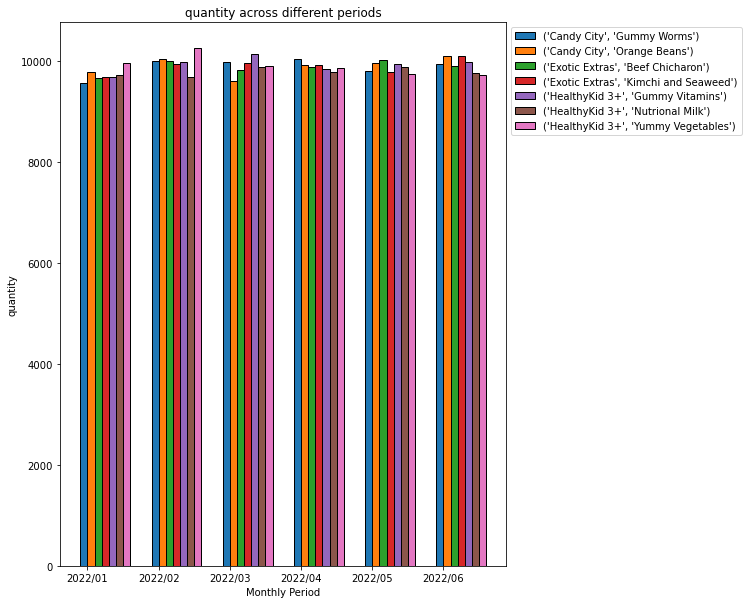

In [23]:
plot_sales_per_item(item_summary_per_month, 'quantity')

## Total Sales per Item Across Monthly Period

As you can see in the plots below, the sales sold for each item is the similar across periods.

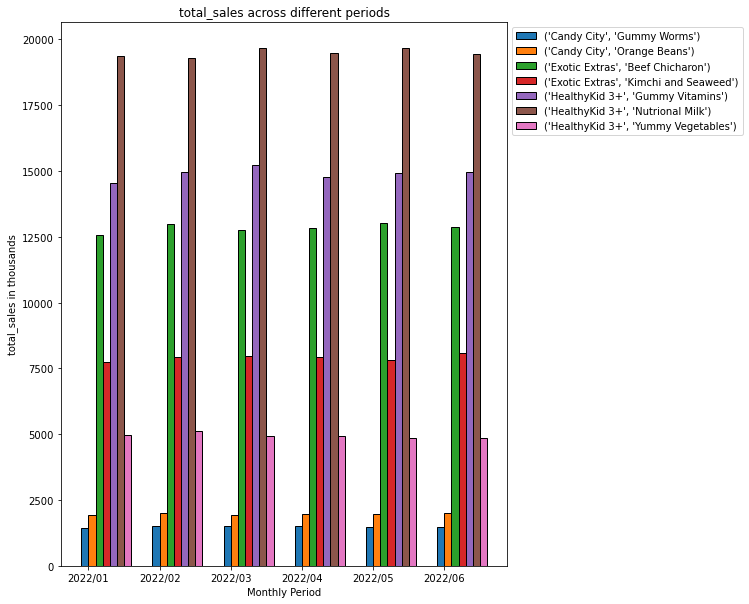

In [24]:
plot_sales_per_item(item_summary_per_month, 'total_sales')

# Top 10 Customers (All Time)

In [39]:
def compute_cost(row, data, unit_cost):
    cost = row['quantity'] * unit_cost[f"{row['brand']},{row['product']}"]
    return cost

def get_top_10_customers(data, param):
    
    #Create a copy 
    df = data.copy()
    
    #Create a copy of the relevant data
    df = data[['username', 'brand', 'product', 'quantity']].copy()
    
    top_10_customers = None
        
    if param == 'quantity':
        top_10_customers = df.groupby('username')['quantity'].sum()
    elif param == 'sales':
        #Get the unit cost of the items
        unit_cost = get_unit_cost(data)
        
        #Create a cost column equal to 
        df['cost'] = df.apply(lambda row: compute_cost(row, data, unit_cost), axis=1)
        
        top_10_customers = df.groupby('username')['cost'].sum()
    else:
        return None
    
    #Get only the first 10 in terms of sales or quantities
    top_10_customers.sort_values(ascending=False, inplace=True)
    top_10_customers = top_10_customers[:10]
    
    return top_10_customers

In [40]:
def plot_top_10_customers(data, param):
    
    #Get the top 10 customers in terms of sales or quantity
    top_10_customers = get_top_10_customers(data, param)
    
    data_dict = {}
    
    for username in top_10_customers.index:
        data_dict[username] = top_10_customers[username]
        
    customers = list(data_dict.keys())
    values = list(data_dict.values())
  
    fig = plt.figure(figsize = (10, 5))
 
    # creating the bar plot
    plt.bar(customers, values, color ='maroon', width = 0.4)

    y_label = 'Total Amount Purchased' if param == 'sales' else 'Total Quantity Purchased'
    
    plt.xlabel('Username')
    plt.ylabel(y_label)
    plt.title(f'Top 10 Customers (All Time) in Terms of {param}')
    plt.show()

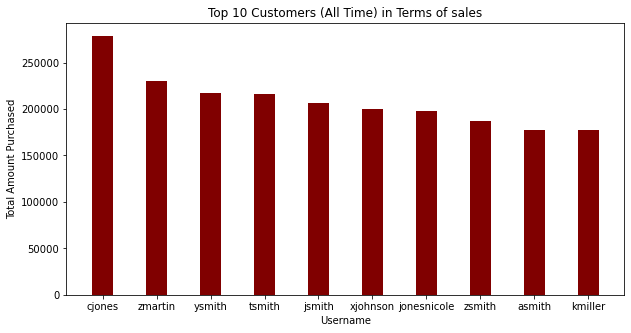

In [41]:
plot_top_10_customers(transformed_data, 'sales')

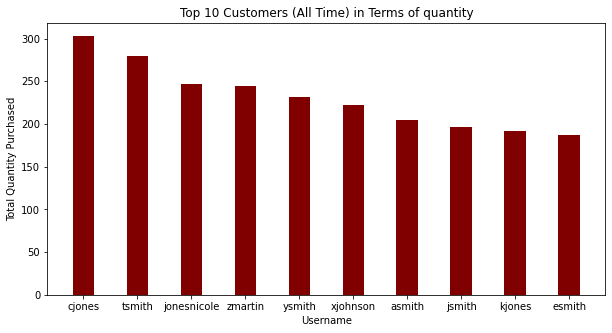

In [42]:
plot_top_10_customers(transformed_data, 'quantity')